Reference: https://www.kaggle.com/code/venkatasubramanian/automatic-ticket-classification-notebook#Topic-Modelling-using-NMF

In [59]:
import pandas as pd
import json
import numpy as np

In [60]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

nltk.download('averaged_perceptron_tagger')
import spacy
nlp = spacy.load("en_core_web_sm")
from textblob import TextBlob
import re

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\dxlee\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dxlee\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dxlee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dxlee\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Data Loading

In [61]:
df = pd.json_normalize(json.load(open("complaints-2021-05-14_08_16_.json")))

# Basic Data Understanding

- getting basic information such as number of variables, observations, sample data, and value frequencies
- identifying data quality issues

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [63]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [64]:
df.tail()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
78308,complaint-public-v2,complaint,3105617,0.0,None,08857,3105617,Closing an account,2018-12-20T12:00:00-05:00,NJ,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2018-12-21T12:00:00-05:00,None,Checking account,Yes,,Funds not received from closed account,Consent not provided
78309,complaint-public-v2,complaint,3091984,0.0,None,934XX,3091984,"Other features, terms, or problems",2018-12-05T12:00:00-05:00,CA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Other problem,Consent provided
78310,complaint-public-v2,complaint,3133355,0.0,None,923XX,3133355,Problem with a lender or other company chargin...,2019-01-25T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-01-25T12:00:00-05:00,None,Checking account,Yes,I am not familiar with XXXX pay and did not un...,Transaction was not authorized,Consent provided
78311,complaint-public-v2,complaint,3110963,0.0,None,None,3110963,"Other features, terms, or problems",2018-12-27T12:00:00-05:00,PA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-27T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I have had flawless credit for 30 yrs. I've ha...,Problem with balance transfer,Consent provided
78312,complaint-public-v2,complaint,2001189,0.0,None,None,2001189,Payment to acct not credited,2016-07-06T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2016-07-07T12:00:00-05:00,None,None,Yes,Roughly 10+ years ago I closed out my accounts...,None,Consent provided


In [65]:
#Assign new column names
df.columns = ['index', 'type', 'id', 'score', 'tags', 'zip_code','complaint_id', 'issue', 'date_received',
       'state', 'consumer_disputed', 'product','company_response', 'company', 'submitted_via',
       'date_sent_to_company', 'company_public_response','sub_product', 'timely',
       'complaint_what_happened', 'sub_issue','consumer_consent_provided']

In [66]:
df.value_counts('type')

type
complaint    78313
Name: count, dtype: int64

In [67]:
df.value_counts('tags')

tags
Older American                   6103
Servicemember                    3759
Older American, Servicemember    1038
Name: count, dtype: int64

In [68]:
df.value_counts('issue')

issue
Loan modification,collection,foreclosure                                           9743
Managing an account                                                                7410
Loan servicing, payments, escrow account                                           5360
Problem with a purchase shown on your statement                                    4055
Account opening, closing, or management                                            3879
                                                                                   ... 
Adding money                                                                          1
Problem with an overdraft                                                             1
Was approved for a loan, but didn't receive the money                                 1
Money was taken from your bank account on the wrong day or for the wrong amount       1
Overdraft, savings or rewards features                                                1
Name: count, Length: 154, 

In [69]:
df.value_counts('consumer_disputed')

consumer_disputed
N/A    35683
No     33107
Yes     9523
Name: count, dtype: int64

In [70]:
df.value_counts('product')

product
Mortgage                                                                        22725
Checking or savings account                                                     12147
Credit card or prepaid card                                                     10797
Credit card                                                                     10373
Bank account or service                                                          9816
Credit reporting, credit repair services, or other personal consumer reports     4310
Debt collection                                                                  3201
Money transfer, virtual currency, or money service                               1500
Consumer Loan                                                                    1029
Vehicle loan or lease                                                             892
Student loan                                                                      866
Money transfers                               

In [71]:
df.value_counts('sub_product')

sub_product
Checking account                              17182
General-purpose credit card or charge card    10504
Other mortgage                                 8447
Conventional fixed mortgage                    4892
Credit reporting                               4172
                                              ...  
Government benefit payment card                   4
Gift or merchant card                             4
Medical debt                                      2
ID prepaid card                                   2
Electronic Benefit Transfer / EBT card            1
Name: count, Length: 72, dtype: int64

In [72]:
df.value_counts('timely')

timely
Yes    78217
No        96
Name: count, dtype: int64

In [73]:
df.value_counts('complaint_what_happened')

complaint_what_happened
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [74]:
df.value_counts('sub_issue')

sub_issue
Credit card company isn't resolving a dispute about a purchase on your statement    2904
Deposits and withdrawals                                                            2759
Company closed your account                                                         2020
Problem using a debit or ATM card                                                   1613
Card was charged for something you did not purchase with the card                   1056
                                                                                    ... 
Problem cancelling or closing account                                                  1
Incorrect information on your report                                                   1
Problem with direct deposit                                                            1
Report shared with employer w/o consent                                                1
Receiving unwanted marketing/advertising                                               1
Name: count

In [75]:
df.value_counts('consumer_consent_provided')

consumer_consent_provided
N/A                     42847
Consent provided        21077
Consent not provided    12285
Other                     991
Consent withdrawn         105
Name: count, dtype: int64

In [76]:
# null or empty values
null_count_df = pd.DataFrame({'columns':df.columns,
                              'empty_string_count':list(map(lambda column: (df[column] == '').sum(), df.columns)),
                              'null_value_count':list(map(lambda column: (df[column] == np.nan).sum(), df.columns))})
null_count_df

,columns,empty_string_count,null_value_count
0,index,0,0
1,type,0,0
2,id,0,0
3,score,0,0
4,tags,0,0
5,zip_code,0,0
6,complaint_id,0,0
7,issue,0,0
8,date_received,0,0
9,state,0,0


In [77]:
# masked values
masked_text_pattern = r"\b[x|X]{2,20}"
masked_df = pd.DataFrame({
    'number_of_masked':df['complaint_what_happened'].apply(lambda text:len(re.findall(masked_text_pattern, text))), 
    'masked':df['complaint_what_happened'].apply(lambda text:re.findall(masked_text_pattern, text))})
df_with_masked = masked_df[masked_df['number_of_masked']!=0]
df_with_masked

,number_of_masked,masked
1,6,"[XXXX, XXXX, XXXX, XXXX, XXXX, XXXX]"
2,12,"[XXXX, XXXX, XX, XX, XXXX, XX, XX, XXXX, XX, X..."
10,2,"[XX, XX]"
11,10,"[XX, XX, XXXX, XXXX, XXXX, XXXX, XX, XX, XX, XX]"
14,4,"[XX, XX, XXXX, XXXX]"
...,...,...
78303,1,[XXXX]
78309,11,"[XX, XX, XXXX, XXXX, XXXX, XX, XX, XXXX, XXXX,..."
78310,8,"[XXXX, XXXX, XXXX, XXXX, XXXX, XXXX, XXXX, XXXX]"
78311,13,"[XXXX, XX, XX, XXXX, XX, XX, XXXX, XX, XX, XXX..."


In [78]:
df_with_masked.value_counts('number_of_masked')

number_of_masked
2       1519
3       1215
1       1201
4       1060
6       1008
        ... 
195        1
196        1
198        1
201        1
1119       1
Name: count, Length: 211, dtype: int64

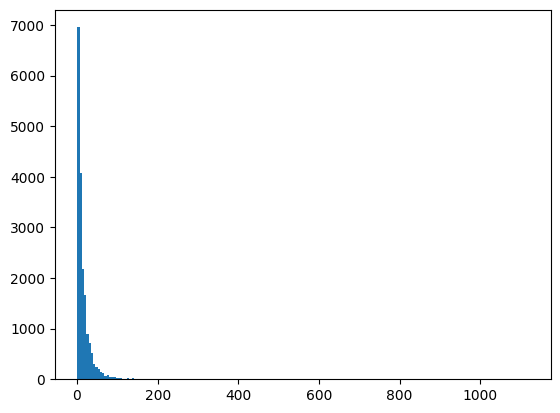

In [79]:
import matplotlib.pyplot as plt

plt.hist(df_with_masked['number_of_masked'],bins=200)
plt.show()

# Initial Data Preprocessing

In [80]:
def clean_text(text):
  # Case-folding (Lowercase)
  text = text.lower()

  # Remove url
  url_pattern = re.compile(r'(https?://\S+)|(www\.\S+)|(\S+\.\S+/\S+)')
  text = url_pattern.sub(r'', text)

  # Remove emoji
  emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                u"\U00002702-\U000027B0"  # other miscellaneous symbols
                                u"\U000024C2-\U0001F251"  # enclosed characters
                              "]+", flags=re.UNICODE)
  text = emoji_pattern.sub(r'', text)

  # Remove Punctuation, and words containing numbers
  punt_pattern = '[^\w\s]'
  word_with_num_pattern = '\w*\d\w*'
  text = re.sub(punt_pattern, '', text)
  text = re.sub(word_with_num_pattern, '', text)

  # Tokenisation
  tokens = word_tokenize(text)

  # Remove stopwords
  stop_words = set(stopwords.words('english'))
  tokens = [word for word in tokens if word not in stop_words]

  return tokens

def lemmatise_with_pos_tagged(tokens):
  lemmatizer = WordNetLemmatizer()
  lemmas = []
  for word, tag in pos_tag(tokens):
    wntag = tag[0].lower()
    wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
    lemmas.append(lemmatizer.lemmatize(word, wntag) if wntag else word)
  return lemmas

def further_clean(tokens):
  # remove repeating characters from tokens
  RepeatTokensRm =  " ".join( [ re.sub(r'(\w)\1{2,}', r'\1', word) for word in tokens] )
  # Remove tokens containing digits
  digitTokensRm =  " ".join( [ word for word in RepeatTokensRm.split() if not re.search(r'\d', word) ] ) 
  # Remove tokens containing underscore
  underscoreTokensRm =  " ".join( [ word for word in digitTokensRm.split() if not re.search(r'_|\w*_\w*', word) ] )
  # Remove tokens containing Special Characters
  specialTokensRm =  " ".join( [ word for word in underscoreTokensRm.split() if not re.search(r'[^a-zA-Z0-9\s]', word) ] )
  # Remove tokens less than 2 characters
  return " ".join( [ word for word in specialTokensRm.split() if len(word) > 2 ] )

In [81]:
def preprocess_text(text):
    tokens = clean_text(text)
    lemmas = lemmatise_with_pos_tagged(tokens)
    preprocessed_text = further_clean(lemmas)
    return preprocessed_text

In [83]:
# drop unnecessary columns
df.drop(['index', 'type', 'id', 'score', 'tags', 'zip_code','complaint_id', 'issue', 'date_received',
       'state', 'consumer_disputed', 'product','company_response', 'company', 'submitted_via',
       'date_sent_to_company', 'company_public_response','sub_product', 'timely',
       'sub_issue','consumer_consent_provided'],axis=1,inplace=True)

# remove values containing empty strings or only whitespaces of complaint_what_happened column
df['complaint_what_happened'].replace(r'^\s*$', np.nan, regex=True, inplace=True)
df.dropna(inplace=True)

# Apply text preprocessing to the 'complaint_what_happened' column
df['preprocessed_text'] = df['complaint_what_happened'].apply(preprocess_text)

# Display the preprocessed text
df.head()

,complaint_what_happened,preprocessed_text
1,Good morning my name is XXXX XXXX and I apprec...,good morning name appreciate could help put st...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded card tell agent upgrade anniversary d...
10,Chase Card was reported on XX/XX/2019. However...,chase card report however fraudulent applicati...
11,"On XX/XX/2018, while trying to book a XXXX XX...",try book ticket come across offer apply toward...
14,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...


In [ ]:
# df_complain_text['complaint_clean'] = df_complain_text['complaint_what_happened'].apply(clean_text)
# print("Done clean")
# df_complain_text['complaint_pos_tagged'] = df_complain_text['complaint_clean'].apply(pos_tagger)
# print("Done lemmatisation")
# df_complain_text['complaint_lemmatise'] = df_complain_text['complaint_pos_tagged'].apply(lemmatise)
# print("POS Tagged")
# df_complain_processed = df_complain_text[['complaint_clean','complaint_what_happened','complaint_pos_tagged','complaint_lemmatise']]
# df_complain_processed

In [ ]:
# remove individual "i", "I", "s", "xxxx", "xxxxxxxx"
# def clean_specific_unigram(sentence):
#     unigram_to_remove = ["i", "I", "s", "xxxxxxxx", "xxxx"]

#     # Remove Punctuation, and words containing numbers
#     for ug in unigram_to_remove:
#         unigram_pattern = f'(\A{ug} )|( {ug} )|( {ug}\Z)'
#         sentence = re.sub(unigram_pattern, ' ', sentence)
#     return sentence

# df_complain_processed['complaint_remove_specific_unigram'] = df_complain_processed['complaint_lemmatise'].apply(clean_specific_unigram)
# df_complain_processed


# Exploratory data analysis

In [84]:
# unigram frequency
from nltk.tokenize import word_tokenize

text = " ".join(list(df['preprocessed_text']))
uni_tokens = word_tokenize(text)
unigram_df = pd.DataFrame({'unigram':uni_tokens})

unigram_freq_df = unigram_df.groupby('unigram').size().reset_index(name='count').sort_values(by='count', ascending=False)
unigram_freq_df.iloc[:49]

,unigram,count
4132,chase,80407
190,account,48725
5984,credit,34088
3654,card,30528
2375,bank,28646
3502,call,26026
18126,payment,21172
28219,would,20319
4086,charge,18181
24852,tell,17532


In [85]:
# bigram
import itertools
from nltk import bigrams
from nltk.tokenize import word_tokenize


text = list(df['preprocessed_text'])
bigrams_2dlist = [list(bigrams(word_tokenize(txt))) for txt in text]
bigrams_flattenlist = list(itertools.chain.from_iterable(bigrams_2dlist))

bigram_df = pd.DataFrame({'bigram':bigrams_flattenlist})

bigram_freq_df = bigram_df.groupby('bigram').size().reset_index(name='count').sort_values(by='count', ascending=False)
bigram_freq_df.iloc[:49]

,bigram,count
108246,"(chase, bank)",12810
155955,"(credit, card)",12797
90307,"(call, chase)",5002
156910,"(credit, report)",3989
112565,"(check, account)",3794
161375,"(customer, service)",3066
120946,"(close, account)",2657
108736,"(chase, credit)",2580
386260,"(morgan, chase)",2478
4830,"(account, chase)",2423


In [86]:
# trigram
import itertools
from nltk import trigrams
from nltk.tokenize import word_tokenize


text = list(df['preprocessed_text'])
trigrams_2dlist = [list(trigrams(word_tokenize(txt))) for txt in text]
trigrams_flattenlist = list(itertools.chain.from_iterable(trigrams_2dlist))

trigram_df = pd.DataFrame({'trigram':trigrams_flattenlist})
trigram_freq_df = trigram_df.groupby('trigram').size().reset_index(name='count').sort_values(by='count', ascending=False)
trigram_freq_df.iloc[:49]

,trigram,count
320741,"(chase, credit, card)",2232
457594,"(credit, card, account)",971
457843,"(credit, card, company)",957
457809,"(credit, card, chase)",725
1005782,"(morgan, chase, bank)",678
14309,"(account, chase, bank)",654
242524,"(call, chase, bank)",599
321101,"(chase, customer, service)",582
243979,"(call, customer, service)",524
1266018,"(receive, letter, chase)",476


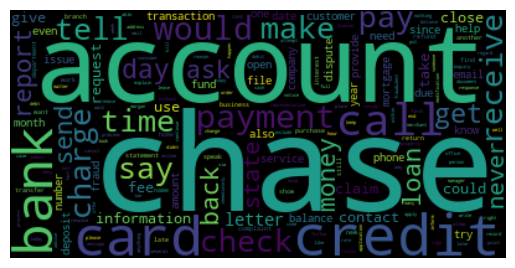

In [87]:
# word cloud of unigrams
d = {}
for a, x in unigram_freq_df.values:
    d[a] = x

import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Topic Modelling

In [ ]:
# generate ticket category
# LDA
# NMF
# Top2Vec
# BERTopic

# evaluate which is the best

# Sentiment Analysis

In [ ]:
# generate ticket priority
# based on overall sentiment score, polarity, and topic frequency
# then abc ranking (20-30-50)



# Word Embedding

use one
- tfidf for ml
- word2vec
- doc2vec
- glove
- fasttext

# Model building
- data partition
- machine learning models
    - SVM
    - KNN
    - LogR
    - NB
    - Dtree
    - random forest
- evaluations
    - accuracy, precision, recall, f1-score